## Supermesh projection by hand with adjoint

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
import firedrake.supermeshing as supermesh

In [8]:
from adapt_utils.plotting import *

Take the hand-coded supermesh projection from notebook `supermesh-by-hand`.

In [2]:
def supermesh_project(src, tgt, check_mass=False, mixed_mass_matrix=None, solver=None):
    source_space = src.function_space()
    target_space = tgt.function_space()
    
    # Step 1: Form the RHS:
    #    rhs := Mst * src
    Mst = mixed_mass_matrix or supermesh.assemble_mixed_mass_matrix(source_space, target_space)
    with tgt.dat.vec_ro as vt:
        rhs = vt.copy()
    with src.dat.vec_ro as vs:
        Mst.mult(vs, rhs)
    
    # Step 2: Solve the linear system for the target:
    #    Mt * tgt = rhs
    ksp = solver or PETSc.KSP().create()
    if solver is None:
        Mt = assemble(inner(TrialFunction(target_space), TestFunction(target_space))*dx).M.handle
        ksp.setOperators(Mt)
        ksp.setFromOptions()
    with tgt.dat.vec as vt:
        ksp.solve(rhs, vt)
    
    if check_mass:
        assert np.allclose(assemble(src*dx), assemble(tgt*dx))

Let's form the adjoint.

Recall the forward and reverse mode of automatic differentiation.

Suppose we want to compute a matrix-vector product:
$$
x := A y\quad\implies\quad\left\{\begin{array}{cc}
x_d := A y_d    & \text{forward mode}\\
y_b := A^T x_b  & \text{reverse mode}
\end{array}\right.
$$

Suppose we want to solve the linear system $Ax=y$ then this is equivalent to computing
$$
x := A^{-1}y\quad\implies\quad\left\{\begin{array}{cccc}
x_d := A^{-1} y_d  & \iff &  A x_d = y_d    & \text{forward mode}\\
y_b := A^{-T} x_b  & \iff &  A^T y_b = x_b  & \text{reverse mode}
\end{array}\right.
$$

The supermesh projection can be written as

$\quad r:=M_{ST}q_S;$

$\quad q_T:=M_T^{-1}r.$

Hence, for a seed vector $(q_T)_b$, the reverse mode looks like

$\quad t:=M_T^{-T}(q_T)_b;$

$\quad (q_S)_b:=M_{ST}^Tt.$

That is, we first solve $M_T^Tt=(q_T)_b$ for $t$ and then multiply by the transpose of the mixed mass matrix.

In [3]:
def supermesh_project_b(tgt_b, src_b, mixed_mass_matrix=None, solver=None):
    source_space = src_b.function_space()
    target_space = tgt_b.function_space()
    
    # Adjoint of step 2: Solve the linear system for the target:
    #    Mt^T * sol = tgt_b
    ksp = solver or PETSc.KSP().create()
    if solver is None:
        Mt = assemble(inner(TrialFunction(target_space), TestFunction(target_space))*dx).M.handle
        ksp.setOperators(Mt.transpose())
        ksp.setFromOptions()
    with tgt_b.dat.vec_ro as rhs:
        sol = rhs.copy()
        ksp.solve(rhs, sol)
    
    # Adjoint of 1: Multiply with the tranpose mass matrix
    #    src_b := Mst^T * sol
    Mst = mixed_mass_matrix or supermesh.assemble_mixed_mass_matrix(source_space, target_space)
    with src_b.dat.vec_ro as vs:
        Mst.multTranspose(sol, vs)

Note that if we write the supermesh projection as

$$q_T = P_{ST} q_S,\qquad\text{where}\qquad P_{ST}:=M_T^{-1} M_{ST}$$

then the adjoint is just

$$(q_S)_b = P_{ST}^T (q_T)_b.$$

Consider the same non-trivial example as before.

In [4]:
Hs = UnitSquareMesh(20, 25, diagonal='left')
Ht = UnitSquareMesh(20, 20, diagonal='right')
Vs = FunctionSpace(Hs, "CG", 1)
Vt = FunctionSpace(Ht, "CG", 1)
xt, yt = SpatialCoordinate(Ht)

In [5]:
t_b_init = Function(Vt, name="Seed")
t_b_init.interpolate(sin(pi*xt)*sin(pi*yt))
t_b = Function(Vt, name="Seed").assign(t_b_init)
s_b = Function(Vs, name="Reverse mode propagation")

In [6]:
supermesh_project_b(t_b, s_b)

<IPython.core.display.Javascript object>


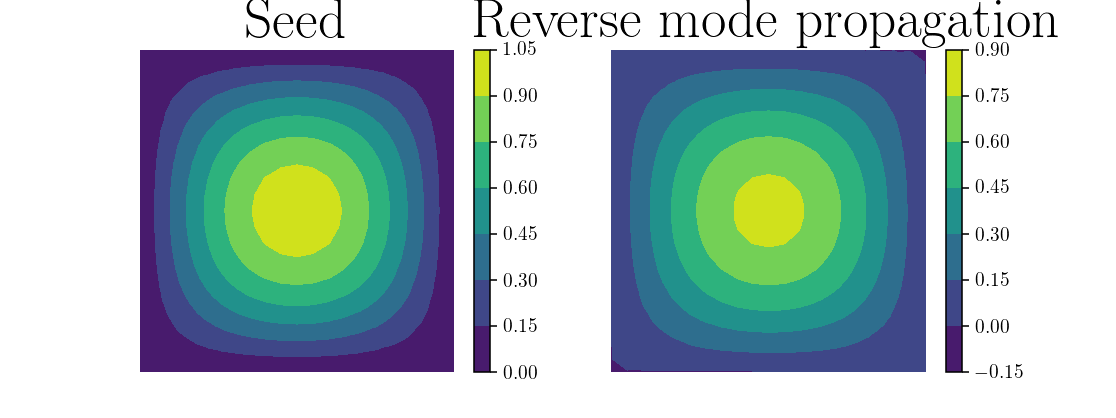

Seed mass = 0.4036
Reverse mode propagation mass = 0.3231
Relative mass error = 19.95%


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for i, f in enumerate((t_b, s_b)):
    cbar = fig.colorbar(tricontourf(f, axes=axes[i]), ax=axes[i])
    cbar.ax.tick_params(labelsize=10)
    axes[i].set_title(f.dat.name)
    axes[i].axis(False)
    print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative mass error = {:.2f}%".format(100*abs(assemble(t_b*dx)-assemble(s_b*dx))/assemble(abs(t_b)*dx)))

<IPython.core.display.Javascript object>


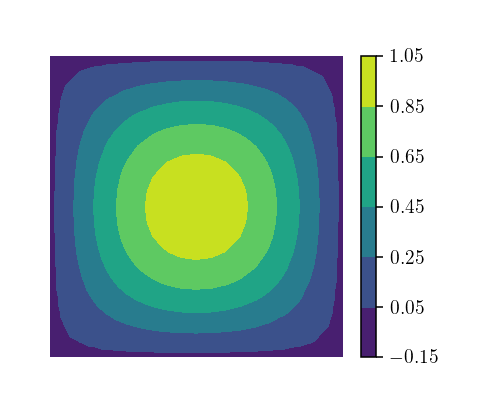

<IPython.core.display.Javascript object>


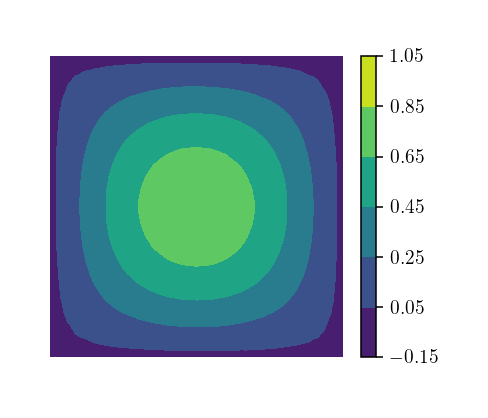

In [16]:
for i, f in enumerate((t_b, s_b)):
    fig, axes = plt.subplots(figsize=(3.5, 3))
    cbar = fig.colorbar(tricontourf(f, axes=axes, levels=np.linspace(-0.15, 1.05, 7)), ax=axes)
    cbar.ax.tick_params(labelsize=10)
    axes.axis(False)
    savefig("_".join(f.dat.name.split()), "plots", ["png"])

We see that, while the propagated profile resembles the seed profile in the eyeball norm, it has a significantly lower mass.
We shouldn't expect it to be conservative, since we are normalising by masses on the wrong space.

Note that the supermesh projection is at the end of the day the solution of an equation.
__It is a general property that the adjoint of an equation written in conservative form is an equation written in non-conservative form, and vice-versa.__

Consider repeatedly applying the operation as a projection operator in both directions:

In [8]:
M_st = supermesh.assemble_mixed_mass_matrix(Vs, Vt)
M_s = assemble(inner(TrialFunction(Vs), TestFunction(Vs))*dx).M.handle
M_t = assemble(inner(TrialFunction(Vt), TestFunction(Vt))*dx).M.handle
M_ts = M_st.copy()
M_ts.transpose();

In [9]:
solver_s = PETSc.KSP().create()
solver_s.setOperators(M_s)
solver_s.setFromOptions()
solver_t = PETSc.KSP().create()
solver_t.setOperators(M_t)
solver_t.setFromOptions()

<IPython.core.display.Javascript object>


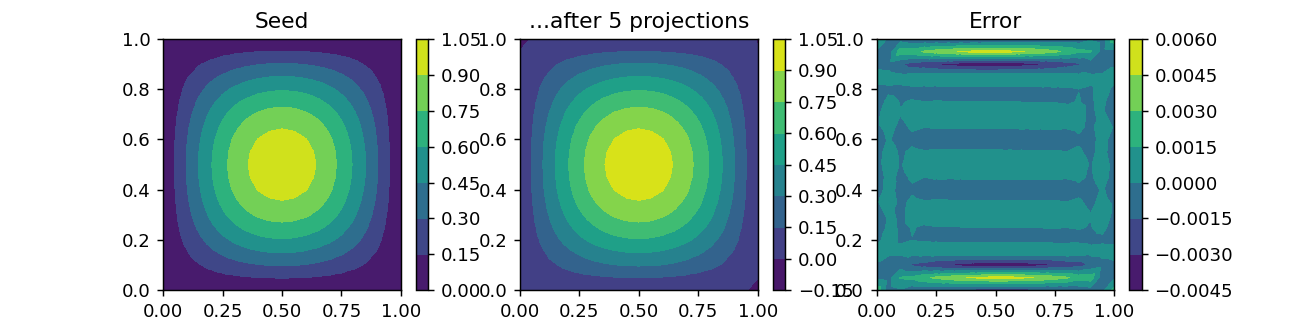

Seed mass = 0.4036
...after 5 projections mass = 0.4036
Relative L2 error = 0.20%
Relative mass error = 0.02%


In [10]:
N = 5
t_b.assign(t_b_init)
for i in range(N):
    supermesh_project_b(t_b, s_b, mixed_mass_matrix=M_st, solver=solver_t)
    supermesh_project_b(s_b, t_b, mixed_mass_matrix=M_ts, solver=solver_s)

t_b.dat.name = "...after {:d} projections".format(N)
err = Function(t_b_init, name="Error")
err -= t_b

fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))
for i, f in enumerate((t_b_init, t_b, err)):
    fig.colorbar(tricontourf(f, axes=axes[i]), ax=axes[i])
    axes[i].set_title(f.dat.name)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*errornorm(t_b, t_b_init)/norm(t_b_init)))
print("Relative mass error = {:.2f}%".format(100*abs(assemble(t_b*dx)-assemble(t_b_init*dx))/assemble(abs(t_b_init)*dx)))

It seems the errors cancel when we project back again. Try more iterations:

<IPython.core.display.Javascript object>


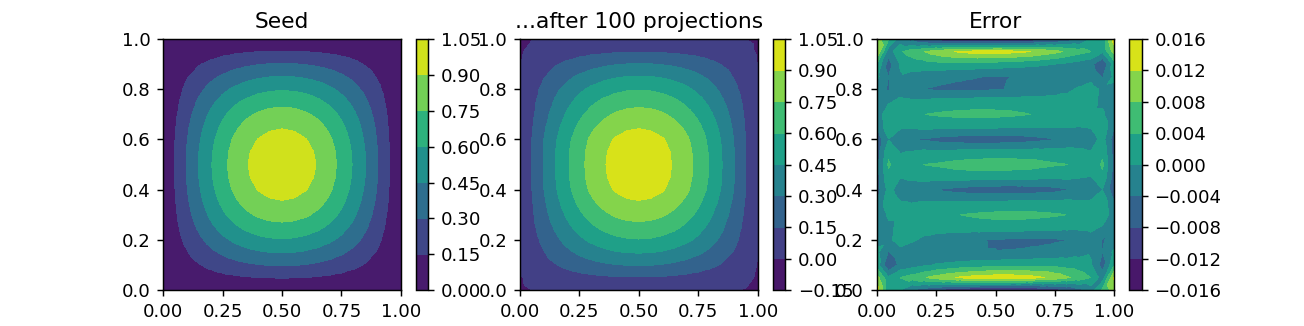

Seed mass = 0.4036
...after 100 projections mass = 0.4032
Relative L2 error = 0.73%
Relative mass error = 0.10%


In [11]:
N = 100
t_b.assign(t_b_init)
for i in range(N):
    supermesh_project_b(t_b, s_b, mixed_mass_matrix=M_st, solver=solver_t)
    supermesh_project_b(s_b, t_b, mixed_mass_matrix=M_ts, solver=solver_s)

t_b.dat.name = "...after {:d} projections".format(N)
err = Function(t_b_init, name="Error")
err -= t_b

fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))
for i, f in enumerate((t_b_init, t_b, err)):
    fig.colorbar(tricontourf(f, axes=axes[i]), ax=axes[i])
    axes[i].set_title(f.dat.name)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*errornorm(t_b, t_b_init)/norm(t_b_init)))
print("Relative mass error = {:.2f}%".format(100*abs(assemble(t_b*dx)-assemble(t_b_init*dx))/assemble(abs(t_b_init)*dx)))

Interestingly, the L2 error is actually _smaller_ than we observed in the previous notebook.

Consider a combination of the two approaches:

<IPython.core.display.Javascript object>


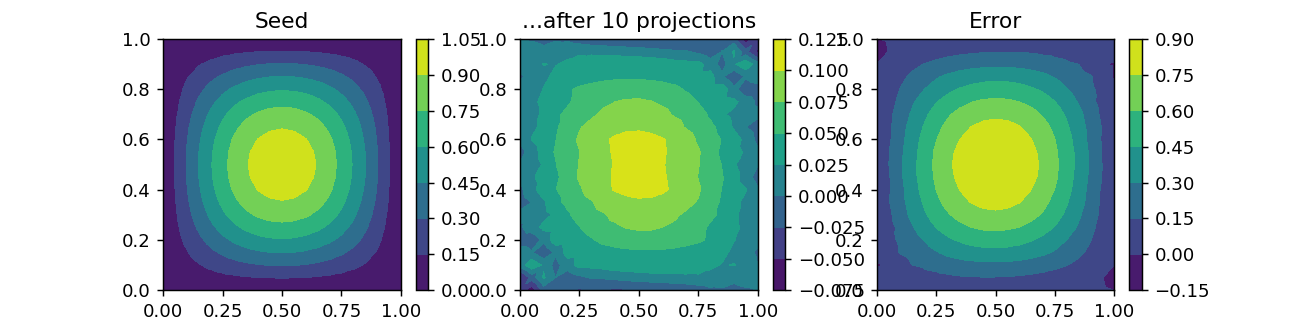

Seed mass = 0.4036
...after 10 projections mass = 0.0433
Relative L2 error = 89.09%
Relative mass error = 89.26%


In [12]:
N = 10
t_b.assign(t_b_init)
for i in range(N):
    supermesh_project(s_b, t_b, mixed_mass_matrix=M_st, solver=solver_t)
    supermesh_project_b(t_b, s_b, mixed_mass_matrix=M_st, solver=solver_t)

t_b.dat.name = "...after {:d} projections".format(N)
err = Function(t_b_init, name="Error")
err -= t_b

fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))
for i, f in enumerate((t_b_init, t_b, err)):
    fig.colorbar(tricontourf(f, axes=axes[i]), ax=axes[i])
    axes[i].set_title(f.dat.name)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*errornorm(t_b, t_b_init)/norm(t_b_init)))
print("Relative mass error = {:.2f}%".format(100*abs(assemble(t_b*dx)-assemble(t_b_init*dx))/assemble(abs(t_b_init)*dx)))

<IPython.core.display.Javascript object>


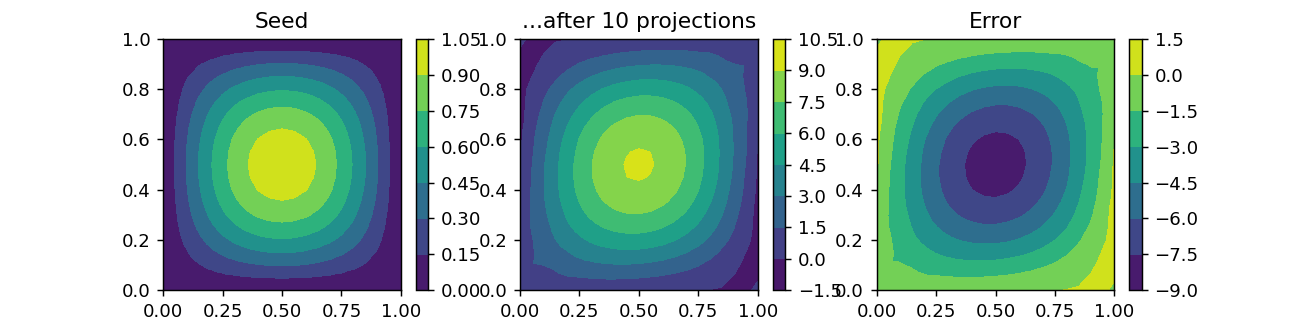

Seed mass = 0.4036
...after 10 projections mass = 3.7324
Relative L2 error = 823.59%
Relative mass error = 824.73%


In [13]:
N = 10
t_b.assign(t_b_init)
for i in range(N):
    supermesh_project(t_b, s_b, mixed_mass_matrix=M_ts, solver=solver_s)
    supermesh_project_b(s_b, t_b, mixed_mass_matrix=M_ts, solver=solver_s)

t_b.dat.name = "...after {:d} projections".format(N)
err = Function(t_b_init, name="Error")
err -= t_b

fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))
for i, f in enumerate((t_b_init, t_b, err)):
    fig.colorbar(tricontourf(f, axes=axes[i]), ax=axes[i])
    axes[i].set_title(f.dat.name)
    if f != err:
        print("{:s} mass = {:.4f}".format(f.dat.name, assemble(f*dx)))
print("Relative L2 error = {:.2f}%".format(100*errornorm(t_b, t_b_init)/norm(t_b_init)))
print("Relative mass error = {:.2f}%".format(100*abs(assemble(t_b*dx)-assemble(t_b_init*dx))/assemble(abs(t_b_init)*dx)))

This doesn't look too good.
While the two projection operators are well behaved on their own, they are not so nice in each other's company!
Although we shouldn't expect the result to be very good, given that `supermesh_project_b` implies a significant loss of mass.